In [269]:
from bs4 import BeautifulSoup
import requests
import lxml
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [62]:
import requests
import pandas as pd

APP_ID = '3e1f9abf'
APP_KEY = 'ae508a7ffa1c98ef71318c41b85d1448'
max_pages = 30


all_jobs = []

for page in range(1, max_pages + 1):
    url = f"https://api.adzuna.com/v1/api/jobs/us/search/{page}"
    params = {
        'app_id': APP_ID,
        'app_key': APP_KEY,
        'what': 'machine learning',
        'where': 'San Francisco',
        'results_per_page': 50,
        'content-type': 'application/json'
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Failed on page {page}")
        break

    results = response.json().get('results', [])
    for job in results:
        all_jobs.append({
            'title': job.get('title'),
            'company': job.get('company', {}).get('display_name'),
            'location': job.get('location', {}).get('display_name'),
            'category': job.get('category', {}).get('label'),
            'description': job.get('description'),
            'contract_type': job.get('contract_type'),
            'contract_time': job.get('contract_time'),
            'created': job.get('created'),
            'salary_min': job.get('salary_min'),
            'salary_max': job.get('salary_max'),
            'salary_avg': (job.get('salary_min') or 0 + job.get('salary_max') or 0) / 2
                if job.get('salary_min') and job.get('salary_max') else None,
            'redirect_url': job.get('redirect_url')
        })

# Convert to DataFrame
df_all_jobs = pd.DataFrame(all_jobs)
print(f"Total jobs collected: {len(df_all_jobs)}")
print(df_all_jobs.head())

Total jobs collected: 1500
                                       title                 company  \
0                  Machine Learning Engineer            Hireio, Inc.   
1  Machine Learning Engineer, Infrastructure  Attentive Mobile, Inc.   
2          Senior Machine Learning Scientist                Freenome   
3          Senior Machine Learning Scientist                Freenome   
4           Senior Machine Learning Engineer                 Klaviyo   

                            location              category  \
0          San Francisco, California               IT Jobs   
1  Financial District, San Francisco      Engineering Jobs   
2         Brisbane, San Mateo County  Scientific & QA Jobs   
3         Brisbane, San Mateo County  Scientific & QA Jobs   
4        Hayes Valley, San Francisco      Engineering Jobs   

                                         description contract_type  \
0  Job Description Job Description Responsible fo...          None   
1  Machine Learning Enginee

In [94]:
df_all_jobs.shape

(1500, 12)

In [121]:
df_all_jobs.to_csv('jobs_adzuna.csv')

In [115]:
df = pd.read_csv('jobs_adzuna.csv')

In [117]:
df = df.drop(columns = 'Unnamed: 0')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1500 non-null   object 
 1   company        1496 non-null   object 
 2   location       1500 non-null   object 
 3   category       1500 non-null   object 
 4   description    1500 non-null   object 
 5   contract_type  69 non-null     object 
 6   contract_time  716 non-null    object 
 7   created        1500 non-null   object 
 8   salary_min     1500 non-null   float64
 9   salary_max     1499 non-null   float64
 10  salary_avg     1493 non-null   float64
 11  redirect_url   1500 non-null   object 
dtypes: float64(3), object(9)
memory usage: 140.8+ KB


In [147]:
df['contract_time'].unique()

array([nan, 'full_time', 'part_time'], dtype=object)

In [127]:
category_counts = df['category'].value_counts()
filtered_df = df[df['category'].isin(category_counts[category_counts > 2].index)]

In [176]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

categ = ohe.fit_transform(filtered_df[['category']])

categ = pd.DataFrame(
    categ.toarray(),
    columns= ohe.get_feature_names_out()
)

ctype = ohe.fit_transform(filtered_df[['contract_type']])

ctype = pd.DataFrame(
    ctype.toarray(),
    columns= ohe.get_feature_names_out()
)


ctime = ohe.fit_transform(filtered_df[['contract_time']])

ctime = pd.DataFrame(
    ctime.toarray(),
    columns= ohe.get_feature_names_out()
)

In [177]:
categ.columns = categ.columns.str.replace('category_', '', regex=False)

In [178]:
ctype.columns = ctype.columns.str.replace('contract_type_', '', regex=False)

In [179]:
ctime.columns = ctime.columns.str.replace('contract_time_', '', regex=False)

In [190]:

filtered_df = pd.concat([filtered_df.reset_index(drop = True),categ.reset_index(drop = True)],axis = 1)
filtered_df = pd.concat([filtered_df.reset_index(drop = True),ctype.reset_index(drop = True)],axis = 1)
filtered_df = pd.concat([filtered_df.reset_index(drop = True),ctime.reset_index(drop = True)],axis = 1)


In [192]:
filtered_df = filtered_df.drop(columns=['category', 'contract_type', 'contract_time'])

In [201]:
filtered_df = filtered_df.dropna(subset=['salary_avg'])

In [203]:
num = filtered_df.select_dtypes(include=['float64'])

In [204]:
f = num.drop(columns = ['salary_min', 'salary_max', 'salary_avg'])
t = num['salary_avg']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(f, t, test_size=0.2, random_state=250)


model = LinearRegression()
model.fit(X_train, y_train)



y_pred = model.predict(X_test)

print('\tLinear Regression:')
print(f'R2 square: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

	Linear Regression:
R2 square: 0.08876639642562745
MSE: 576061262.3423289
RMSE: 24001.276264864104


# ENBEK.KZ


In [3]:

url = "https://enbek.kz/kk/search/vacancy?except[subsidized]=subsidized&page="

headers = {
    "accept": "*/*",
    "user-agent":  "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36"
}

titles = []
fields = []
salaries = []
locations = []
cities = []
experiences = []
enrollment_statuses = []
educations = []
dates = []
job_places = []
demandss = []
responsibilitiess = []
professional_skillss = []
skills = []
subtitles = []
languagess = []
employment_types = []
working_conditionss = []
internship_infos = []





def scraping_page(url):

    req = requests.get(url, headers = headers)
    src = req.text

    soup = BeautifulSoup(src, "lxml")

    jobs = soup.find(class_="row").find_all(class_="item-list")




    for job in jobs:

        
        try:
            href = job.find(class_="me-1").find("a",class_="stretched")['href']
            job_url = f'https://enbek.kz{href}'
            job_response = requests.get(job_url, headers=headers, timeout=10)  
            job_soup = BeautifulSoup(job_response.text, 'lxml')
            jobb = job_soup.find(class_="col-lg-9 order-0").find(class_="bordered-box item mb-3")
        except (AttributeError, requests.exceptions.RequestException):
            continue


        
        try:
            title = job.find(class_="me-1").find("a",class_="stretched").text.strip()
        except AttributeError:
            title = np.nan

        try:
            subtitle = job.find("div",class_= "subtitle").text.strip()
        except AttributeError:
            subtitle = np.nan

        
        try:
            field = job.find(class_="profobl").find("span").text.strip()
        except AttributeError:
            field = np.nan

        try:
            salary = job.find(class_="price").text.strip()
        except AttributeError:
            salary = np.nan

        try:
            location = job.find("li", class_="company d-flex align-items-center is-valid").text.strip()
        except AttributeError:
            location = np.nan

        try: 
            city = job.find("li", class_="location d-flex align-items-center me-lg-3").text.strip()
        except AttributeError:
            city = np.nan

        try:
            experience = job.find("li", class_="experience d-flex align-items-center").text.strip()
        except AttributeError:
            experience = np.nan

        try: 
            enrollment_status = job.find("li", class_="time d-flex align-items-center me-lg-3").text.strip()
        except AttributeError:
            enrollment_status = np.nan

        try:
            education = job.find("li", class_="education d-flex align-items-center").text.strip()
        except AttributeError:
            education = np.nan

        try:
            date = job.find("div", class_="right-content ms-lg-auto").find("span").text.strip()
        except AttributeError:
            date = np.nan


        
        internship_info = np.nan
        working_conditions = np.nan
        employment_type = np.nan



        oo = []
        qq = jobb.find_all("li")
        for ppp in qq:
            oo.append(ppp.text.strip())
        for zz in oo:
            if zz.startswith("Жұмыспен қамту түрі"):
                employment_type = zz.split('\n', 1)[-1].strip()
            elif zz.startswith("Еңбек жағдайы"):
                working_conditions = zz.split('\n', 1)[-1].strip()
            elif zz.startswith("Тағылымдамадан өту"):
                internship_info = zz.split('\n', 1)[-1].strip()
        

        text = jobb.find(class_ = "text").find_all(class_ = "single-line")

        job_place = np.nan
        demands = np.nan
        responsibilities = np.nan
        professional_skills = np.nan
        skill = np.nan
        languages = np.nan


        
        for t in text:
            if t.find(class_ = "label").text.strip()=='Жұмыс орындары':
                job_place = t.find(class_ = 'value').text.strip()
            elif t.find(class_ = "label").text.strip()=='Біліктілікке қойылатын талаптар':
                demands = t.find(class_ = 'value').text.strip()
            elif t.find(class_ = "label").text.strip()=='Міндеттері':
                responsibilities = t.find(class_ = 'value').text.strip()
            elif t.find(class_ = "label").text.strip()=='Кәсіби дағдылар':
                professional_skills = t.find(class_ = 'value').text.strip()
            elif t.find(class_ = "label").text.strip()=='Жеке қасиеті':
                skill = t.find(class_ = 'value').text.strip()
            elif t.find(class_ = "label").text.strip()=='Меңгерген тілдері':
                languages = t.find(class_ = 'value').text.strip()
        
 
        titles.append(title)
        fields.append(field)
        salaries.append(salary)
        locations.append(location)
        cities.append(city)
        experiences.append(experience)
        enrollment_statuses.append(enrollment_status)
        educations.append(education)
        dates.append(date)
        job_places.append(job_place)
        demandss.append(demands)
        responsibilitiess.append(responsibilities)
        professional_skillss.append(professional_skills)
        skills.append(skill)
        subtitles.append(subtitle)
        languagess.append(languages)
        employment_types.append(employment_type)
        working_conditionss.append(working_conditions)
        internship_infos.append(internship_info)


for page_num in range(300, 650):
    
    page_url = f"{url}{page_num}"
    
    scraping_page(page_url)
  
    time.sleep(3)




In [19]:

dff = pd.DataFrame({
    'Titles': titles,
    'SubTitle' : subtitles,
    'Fields': fields,
    'Salaries': salaries,
    'Locations': locations,
    'Cities': cities,
    'Experiences': experiences,
    'Enrollment_statuses': enrollment_statuses,
    'Employment type':employment_types,
    'Working Condition': working_conditionss,
    'Internship info': internship_infos,
    'Educations': educations,
    'Dates': dates,
    'Job Places' : job_places,
    'Demands': demandss,
    'Responsibilities': responsibilitiess,
    'Professional skills': professional_skillss,
    'Soft skills' : skills,
    'Languages' : languagess,
})

In [427]:
import pandas as pd

dff = pd.read_csv('AI_enbek_kz.csv')


In [429]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   combined_text        5412 non-null   object 
 1   Working Condition    5412 non-null   float64
 2   Educations           5412 non-null   float64
 3   Kazakh               5412 non-null   int64  
 4   Russian              5412 non-null   int64  
 5   English              5412 non-null   int64  
 6   Chinese              5412 non-null   int64  
 7   Turkish              5412 non-null   int64  
 8   seasonal             5412 non-null   float64
 9   permanent            5412 non-null   float64
 10  temporary            5412 non-null   float64
 11  remote               5412 non-null   float64
 12  unpaid_intern        5412 non-null   float64
 13  paid_intern          5412 non-null   float64
 14  no_intern            5412 non-null   float64
 15  Abay_reg             5412 non-null   f

# PreProcessing

In [488]:
print(dff.isnull().sum())

Titles                    0
SubTitle                256
Fields                   36
Salaries                 39
Locations                20
Cities                    0
Experiences               0
Enrollment_statuses      39
Employment type           0
Working Condition        39
Internship info          96
Educations                4
Dates                     0
Job Places                0
Demands                1898
Responsibilities       1160
Professional skills     217
Soft skills             149
Languages              1562
dtype: int64


In [493]:
dff = dff.dropna(subset=['Salaries'])

In [24]:
dff['SubTitle'].fillna('Not Given',inplace = True)

C:\Users\Фархат\AppData\Local\Temp\ipykernel_7092\2544205597.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dff['SubTitle'].fillna('Not Given',inplace = True)


In [494]:
print(dff.isnull().sum())

Titles                    0
SubTitle                238
Fields                   36
Salaries                  0
Locations                20
Cities                    0
Experiences               0
Enrollment_statuses       0
Employment type           0
Working Condition         0
Internship info          57
Educations                4
Dates                     0
Job Places                0
Demands                1859
Responsibilities       1160
Professional skills     178
Soft skills             149
Languages              1547
dtype: int64


In [26]:
dff['Fields'].fillna('Not Given',inplace = True)
dff['Locations'].fillna('Not Given',inplace = True)
dff['Internship info'].fillna('Not Given',inplace = True)
dff['Responsibilities'].fillna('Not Given',inplace = True)
dff['Demands'].fillna('Not Given',inplace = True)
dff['Professional skills'].fillna('Any',inplace = True)
dff['Soft skills'].fillna('Any',inplace = True)
dff['Languages'].fillna('Not Given',inplace = True)

C:\Users\Фархат\AppData\Local\Temp\ipykernel_7092\1304569277.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dff['Fields'].fillna('Not Given',inplace = True)
C:\Users\Фархат\AppData\Local\Temp\ipykernel_7092\1304569277.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [27]:
print(dff.isnull().sum())

Titles                 0
SubTitle               0
Fields                 0
Salaries               0
Locations              0
Cities                 5
Experiences            0
Enrollment_statuses    0
Employment type        0
Working Condition      0
Internship info        0
Educations             0
Dates                  0
Job Places             0
Demands                0
Responsibilities       0
Professional skills    0
Soft skills            0
Languages              0
dtype: int64


In [28]:
dff.Languages.unique()

array(['Not Given', 'Қазақ / орташа деңгей',
       'Қазақ / жоғары деңгей\n  Орыс / жоғары деңгей\n Ағылшын / жетік деңгей',
       'Қазақ / жоғары деңгей\n  Орыс / жоғары деңгей',
       'Қазақ / жоғары деңгей',
       'Қазақ / орташа деңгей\n  Орыс / орташа деңгей',
       'Қазақ / жетік деңгей', 'Ағылшын / жоғары деңгей',
       'Орыс / жоғары деңгей\n   Қазақ / жоғары деңгей',
       'Қазақ / жетік деңгей\n  Орыс / жоғары деңгей',
       'Қазақ / бастапқы деңгей', 'Орыс / жетік деңгей',
       'Қазақ / жоғары деңгей\n  Орыс / жетік деңгей',
       'Қазақ / жетік деңгей\n  Орыс / жетік деңгей',
       'Қазақ / жоғары деңгей\n  Орыс / бастапқы деңгей',
       'Ағылшын / жетік деңгей',
       'Қазақ / жоғары деңгей\n  Орыс / орташа деңгей',
       'Орыс / жоғары деңгей',
       'Қазақ / жетік деңгей\n  Орыс / жетік деңгей\n Ағылшын / бастапқы деңгей',
       'Орыс / орташа деңгей\n   Қазақ / жоғары деңгей',
       'Қазақ / жоғары деңгей\n Ағылшын / жоғары деңгей\n  Орыс / жоғары деңг

In [29]:
lang_series = dff['Languages'] 

split_languages = lang_series.dropna().apply(lambda x: [part.strip() for part in x.split('\n')])

In [30]:
level_map = {
    'бастапқы деңгей': 1, 
    'орташа деңгей': 2,    
    'жоғары деңгей': 3,    
    'жетік деңгей': 4      
}


def parse_lang_level(s):
    try:
        lang, level = [part.strip() for part in s.split('/') if part]
        return lang, level_map.get(level, 0)
    except:
        return None, 0

def extract_langs(row):
    if pd.isnull(row):
        return {}
    entries = row.split('\n')
    lang_levels = {}
    for entry in entries:
        lang, score = parse_lang_level(entry)
        if lang:
            lang_levels[lang] = max(score, lang_levels.get(lang, 0))  
    return lang_levels

lang_data = lang_series.apply(extract_langs)
lang_df = pd.DataFrame(lang_data.tolist()).fillna(0).astype(int)

In [31]:
lang_df.rename(columns={'Қазақ': 'Kazakh', 'Орыс': 'Russian', 'Ағылшын': 'English', 'Қытай': 'Chinese', 'Түрік': 'Turkish'}, inplace=True)

In [32]:
dff

,Titles,SubTitle,Fields,Salaries,Locations,Cities,Experiences,Enrollment_statuses,Employment type,Working Condition,Internship info,Educations,Dates,Job Places,Demands,Responsibilities,Professional skills,Soft skills,Languages
0,Үй-жайларды тазалаушы,Уборщица,Біліктілігі жоқ мамандықтар,от 120 000 до 130 000 тг.,"Павлодар облысының әкімдігі, Павлодар облысыны...","Павлодар облысы, Павлодар қ.",Еңбек өтілі жоқ,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жалпы орта (1 сыныптан 11/12 сыныптарға дейін),06.05.2025 жарияланды,1,Not Given,Not Given,Өндірістік үй-жайларды жинау;\n ...,Жауапкершілік;\n ...,Not Given
1,Бас аспаз,шеф повар,Тұру және тамақтану,от 100 000 до 120 000 тг.,"Алматы қаласы Білім басқармасының ""№1 арнаулы ...","Алматы қ., Түркісіб ауданы",Еңбек өтілі жоқ,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,техникалық және кәсіби,06.05.2025 жарияланды,1,Not Given,Not Given,Тамақ өнімдерін дайындау;,Ойлау икемділігі;,Not Given
2,Инженер-конструктор,Not Given,Өндіріс,от 250 000 до 350 000 тг.,"""A.D.S.company"" жауапкершілігі шектеулі серікт...","Қарағанды облысы, Қарағанды қ., Қазыбек би аты...",6 жыл жұмыс өтілі,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жоғары,06.05.2025 жарияланды,1,Not Given,Not Given,проектирование и моделирование с помощью CAD-п...,Жауапкершілік;,Not Given
3,Күзетші,Not Given,Біліктілігі жоқ мамандықтар,от 85 000 до 120 000 тг.,"""Қызылорда облысының білім басқармасының Сырда...","Қызылорда облысы, Сырдария ауданы, Қоғалыкөл а.",Еңбек өтілі жоқ,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жалпы орта (1 сыныптан 11/12 сыныптарға дейін),06.05.2025 жарияланды,1,Not Given,Not Given,Мүліктің сақталуын қадағалау;\n ...,Жауапкершілік;,Not Given
4,Автомобиль жүргізушісі,водитель,Көлік және логистика,от 100 000 до 150 000 тг.,"Алматы қаласы Білім басқармасының ""№1 арнаулы ...","Алматы қ., Түркісіб ауданы",1 жыл жұмыс өтілі,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жалпы орта (1 сыныптан 11/12 сыныптарға дейін),06.05.2025 жарияланды,1,Not Given,Not Given,Автомобильді жүргізе білу;\n ...,Жауапкершілік;,Not Given
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,Ұсімдіктерді күтіп ұстау жөніндегі жұмысшы,Садовник,Біліктілігі жоқ мамандықтар,85 000 тг. бастап,"""Smart2020"" жауапкершілігі шектеулі серіктестігі","Астана қ., ""Байқоңыр"" ауданы",Еңбек өтілі жоқ,толық емес жұмыс күні,тұрақты,қалыпты,Болжанбайды,жалпы орта (1 сыныптан 11/12 сыныптарға дейін),02.05.2025 жарияланды,1,Not Given,Уход за деревьями и газоном на территории котт...,Өсіп-өну кезінде өсімдіктерге күтім жасау;,Дербестік және жауапкершілік;,Орыс / орташа деңгей
3496,Тәрбиешінің көмекшісі,помощник воспитателя в мини центр Ботақан на в...,Білім беру және тәрбиелеу,от 100 000 до 120 000 тг.,Қарағанды облысы білім басқармасының Қарағанды...,"Қарағанды облысы, Қарағанды қ., Қазыбек би аты...",Еңбек өтілі жоқ,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,техникалық және кәсіби,02.05.2025 жарияланды,1,Not Given,Not Given,Тәрбие іс-шараларын өткізу;\n ...,Жауапкершілік;,Қазақ / жоғары деңгей\n Орыс / жоғары деңгей
3497,Тәрбиешінің көмекшісі,помощник воспитателя,Білім беру және тәрбиелеу,87 000 тг. бастап,«Жетісу облысы білім басқармасының Ескелді ауд...,"Жетісу облысы, Ескелді ауданы, Матай Баисов а.",Еңбек өтілі жоқ,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жалпы орта (1 сыныптан 11/12 сыныптарға дейін),02.05.2025 жарияланды,1,Not Given,Not Given,работа с детми;\n ...,Жауапкершілік;\n ...,Not Given
3498,Сатып алушы,Государственный закупщик,Қаржы және бухгалтерлік есеп,219 511 тг. бастап,Батыс Қазақстан облысының әкімдігі білім басқа...,"Батыс Қазақстан облысы, Орал қ.",4 жыл жұмыс өтілі,толық жұмыс күні,тұрақты,қалыпты,Болжанбайды,жоғары,02.05.2025 жарияланды,1,Not Given,Not Given,"Ұсынылған тауарлардың, жұмыстардың сапасын тек...",Жауапкершілік;\n ...,Not Given


In [33]:
dff = dff.reset_index(drop=True)
lang_df = lang_df.reset_index(drop=True)

In [35]:
dff = pd.concat([dff, lang_df], axis=1)

In [36]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3432 entries, 0 to 3431
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Titles               3432 non-null   object
 1   SubTitle             3432 non-null   object
 2   Fields               3432 non-null   object
 3   Salaries             3432 non-null   object
 4   Locations            3432 non-null   object
 5   Cities               3427 non-null   object
 6   Experiences          3432 non-null   object
 7   Enrollment_statuses  3432 non-null   object
 8   Employment type      3432 non-null   object
 9   Working Condition    3432 non-null   object
 10  Internship info      3432 non-null   object
 11  Educations           3432 non-null   object
 12  Dates                3432 non-null   object
 13  Job Places           3432 non-null   object
 14  Demands              3432 non-null   object
 15  Responsibilities     3432 non-null   object
 16  Profes

In [37]:
import re

def extract_mean(s):

    s = str(s)
    

    numbers = re.findall(r'\d+\s*\d*', s)
    

    numbers = [int(num.replace(" ", "")) for num in numbers]
    

    if len(numbers) == 2:
        return sum(numbers) / len(numbers)
    elif len(numbers) == 1:
        return numbers[0]
    else:
        return 0


dff['Salaries'] = dff['Salaries'].apply(extract_mean)
dff['Salaries'] = dff['Salaries'].astype(int)
dff['Experiences'] = dff['Experiences'].apply(extract_mean)
dff['Salaries'] = dff['Salaries'].astype(int)


dff['Dates'] = dff['Dates'].str.extract(r'(\d{2}\.\d{2}\.\d{4})')
dff['Cities'] = dff['Cities'].str.split(',').str[0]

In [38]:
dff['Professional skills'] = dff['Professional skills'].apply(lambda x: [task.strip() for task in x.split('.') if task.strip()])

In [39]:
dff['Soft skills'] = (
    dff['Soft skills'] 
    .astype(str)
    .str.replace(r'\\n', ' ', regex=True)         
    .str.replace(r'\s+', ' ', regex=True)          
    .str.strip()                                   
)

dff['Soft skills'] = dff['Soft skills'].apply(
    lambda x: [q.strip() for q in x.split(';') if q.strip() and q.lower() != 'any']
)

In [490]:
condition_map = {
    'қалыпты': 0,
    'ауыр және зиян': 1,
    'аса ауыр және аса зиян': 2
}

dff['Working Condition'] = dff['Working Condition'].map(condition_map)

In [52]:
dff.drop(columns = ['Employment type'])

dff = dff.rename(columns ={'уақытша': 'temporary', 'тұрақты': 'permanent', 'қашықтан': 'remote', 'маусымдық': 'seasonal'})

In [41]:
dff['Internship info'] = dff['Internship info'].replace('Not Given', np.nan)

In [42]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder()

bb = ohe.fit_transform(dff['Employment type'].values.reshape(-1,1))

bb = pd.DataFrame(
    bb.toarray(),
    columns=ohe.get_feature_names_out()
)

bb.columns = [col.replace('x0_', '') for col in bb.columns]


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(dff[['Internship info']])

encoded_df = pd.DataFrame(
    encoded,
    columns=[col.split('_')[-1] for col in ohe.get_feature_names_out()]
)

dff = pd.concat([dff.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [43]:
dff = pd.concat([dff,bb],axis = 1)

In [54]:
dff = dff.drop(columns = ['nan'])

In [45]:

dff = dff.rename(columns = {'Болжанады, төленбейді': 'unpaid_intern', 'Болжанады, төленеді': 'paid_intern', 'Болжанбайды': 'no_intern'})

In [46]:
encoded = ohe.fit_transform(dff[['Cities']])


encoded_df = pd.DataFrame(encoded, columns=[col.split('_')[-1] for col in ohe.get_feature_names_out()])


dff = pd.concat([dff.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [47]:

dff = dff.rename(columns = {
    'Абай облысы': 'Abay_reg', 'Алматы облысы': 'Almaty_reg', 'Астана қ.': 'Astana', 
    'Алматы  қ.': 'Almaty', 'Атырау облысы': 'Atyrau_reg', 'Ақмола облысы': 'Aqmola_reg', 'Ақтөбе облысы': 'Aqtobe_reg', 
    'Батыс Қазақстан облысы': 'West_kz_reg', 'Жамбыл облысы': 'Zhambyl_reg', 'Жетісу облысы': 'Zhetisu_reg', 'Маңғыстау облысы': 'Mangistau_reg', 
    'Павлодар облысы': 'Pavlodar_reg', 'Солтүстік Қазақстан облысы': 'North_kz_reg', 'Түркістан облысы': 'Turkistan_reg', 'Шымкент қ.': 'Shymkent', 
    'Шығыс Қазақстан облысы': 'East_kz_reg', 'Қарағанды облысы': 'Qaragandy_reg', 'Қостанай облысы': 'Qostanay_reg', 'Қызылорда облысы': 'Qyzylorda_reg', 
    'Ұлытау облысы': 'Ulytau_reg'})

In [48]:



dff['Enrollment_statuses'].unique()

encoded = ohe.fit_transform(dff[['Enrollment_statuses']])


encoded_df = pd.DataFrame(encoded, columns=[col.split('_')[-1] for col in ohe.get_feature_names_out()])


dff = pd.concat([dff.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [49]:

dff = dff.rename(columns = {
    'толық жұмыс күні': 'full_day', 'басқа спецификалық жұмыстар': 'other_specific_jobs', 'толық емес жұмыс күні': 'part_time',
    'вахталық әдіс': 'shift_based', 'ауысымды': 'rotational', 'толық емес жұмыс аптасы': 'part_time_work_week'})

In [50]:
dff = dff.drop(columns=['Enrollment_statuses','Cities','Employment type', 'Internship info'])

In [114]:
data.to_csv('AI_enbek_kz_cleaned.csv',index = False)

In [111]:
data = pd.concat([data,dff], axis = 0)

In [115]:
data.shape

(5412, 52)

In [128]:
data = pd.read_csv('AI_enbek_kz_cleaned.csv')

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Titles               5412 non-null   object 
 1   SubTitle             5412 non-null   object 
 2   Fields               5412 non-null   object 
 3   Salaries             5412 non-null   int64  
 4   Locations            5412 non-null   object 
 5   Experiences          5412 non-null   int64  
 6   Working Condition    5412 non-null   object 
 7   Educations           5408 non-null   object 
 8   Dates                5412 non-null   object 
 9   Job Places           5412 non-null   int64  
 10  Demands              5412 non-null   object 
 11  Responsibilities     5411 non-null   object 
 12  Professional skills  5412 non-null   object 
 13  Soft skills          5412 non-null   object 
 14  Kazakh               5412 non-null   int64  
 15  Russian              5412 non-null   i

In [489]:
education_mapping = {
    'жалпы орта (1 сыныптан 11/12 сыныптарға дейін)': 1,
    'ортадан кейін': 2,
    'техникалық және кәсіби': 3,
    'жоғары': 4,
    'жоғары оқу орыннан кейін': 5
}

dff['Educations'] = dff['Educations'].map(education_mapping)

In [298]:
data['Locations'].value_counts()

Locations
КҚКжОО Еңбек                                                                                                                                                122
Not Given                                                                                                                                                    91
"Qarmet" Акционерлік қоғамы                                                                                                                                  85
"Біріккен ЭнергоСервистік Компаниясы" акционерлік қоғамы                                                                                                     83
"ЭПК-forfait" (ЭПК-форфайт) жауапкершілігі шектеулі серіктестігі                                                                                             54
                                                                                                                                                           ... 
«Атырау облысы Білім беру басқ

In [63]:
data = pd.read_csv('AI_enbek_kz_cleaned.csv')

In [93]:
df.describe()

,Salaries,Experiences,Job Places,Kazakh,Russian,English,Chinese,Turkish,seasonal,permanent,...,Qaragandy_reg,Qostanay_reg,Qyzylorda_reg,Ulytau_reg,rotational,other_specific_jobs,shift_based,part_time_work_week,part_time,full_day
count,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,...,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.000000,5412.00000,5412.000000
mean,194563.378418,1.092572,1.864930,0.554878,0.507391,0.046378,0.001293,0.001848,0.016445,0.895233,...,0.085735,0.099593,0.018662,0.019401,0.028825,0.001478,0.012565,0.002402,0.04952,0.905026
std,114186.885996,1.598640,4.332901,1.176583,1.127495,0.380003,0.059243,0.079247,0.127191,0.306281,...,0.279999,0.299485,0.135342,0.137944,0.167329,0.038422,0.111396,0.048957,0.21697,0.293206
min,60000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,110000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,169489.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,243700.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,999999.000000,10.000000,99.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [86]:
import seaborn as sns
from matplotlib import pyplot as plt

In [251]:
df['Experiences'].value_counts()

Experiences
0     2736
1     1334
3      729
2      296
5      214
10      38
4       35
6       13
8        9
7        6
9        2
Name: count, dtype: int64

In [380]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(num_features)

['Salaries', 'Experiences', 'Working Condition', 'Educations', 'Job Places', 'Kazakh', 'Russian', 'English', 'Chinese', 'Turkish', 'seasonal', 'permanent', 'temporary', 'remote', 'unpaid_intern', 'paid_intern', 'no_intern', 'Abay_reg', 'Almaty', 'Almaty_reg', 'Astana', 'Atyrau_reg', 'Aqmola_reg', 'Aqtobe_reg', 'West_kz_reg', 'Zhambyl_reg', 'Zhetisu_reg', 'Mangistau_reg', 'Pavlodar_reg', 'North_kz_reg', 'Turkistan_reg', 'Shymkent', 'East_kz_reg', 'Qaragandy_reg', 'Qostanay_reg', 'Qyzylorda_reg', 'Ulytau_reg', 'rotational', 'other_specific_jobs', 'shift_based', 'part_time_work_week', 'part_time', 'full_day']


In [382]:
true_numeric_features = [col for col in num_features if data[col].nunique() > 6]
print(true_numeric_features)

['Salaries', 'Experiences', 'Job Places']


In [455]:
num = data[num_features].drop(columns= ['Salaries'])

In [276]:
num['Job Places'] = np.log1p(ss['Job Places'])

In [277]:
ss['Job Places'] = ss['Job Places'].clip(upper=50)

In [278]:
from scipy.stats import zscore

ss['Job Places'] = zscore(ss['Job Places'])
filtered_data = ss[abs(ss['Job Places']) <= 3]

In [279]:
Q1 = ss['Job Places'].quantile(0.25)
Q3 = ss['Job Places'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = ss[(ss['Job Places'] >= lower_bound) & (ss['Job Places'] <= upper_bound)]

### Robust

In [15]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
num[true_numeric_features] = robust_scaler.fit_transform(num[true_numeric_features])

C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\422835712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num[true_numeric_features] = robust_scaler.fit_transform(num[true_numeric_features])


In [16]:
num

,Salaries,Experiences,Working Condition,Educations,Job Places,Kazakh,Russian,English,Chinese,Turkish,...,Qaragandy_reg,Qostanay_reg,Qyzylorda_reg,Ulytau_reg,rotational,other_specific_jobs,shift_based,part_time_work_week,part_time,full_day
0,0.340396,2.0,0.0,2.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.013844,1.0,1.0,3.0,0.0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.631930,4.0,0.0,1.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.415191,5.0,0.0,4.0,0.0,3,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.444944,0.0,0.0,2.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,-0.631930,0.0,0.0,1.0,0.0,0,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5408,-0.444944,0.0,0.0,3.0,0.0,3,3,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5409,-0.616971,0.0,0.0,1.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5410,0.374136,4.0,0.0,4.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


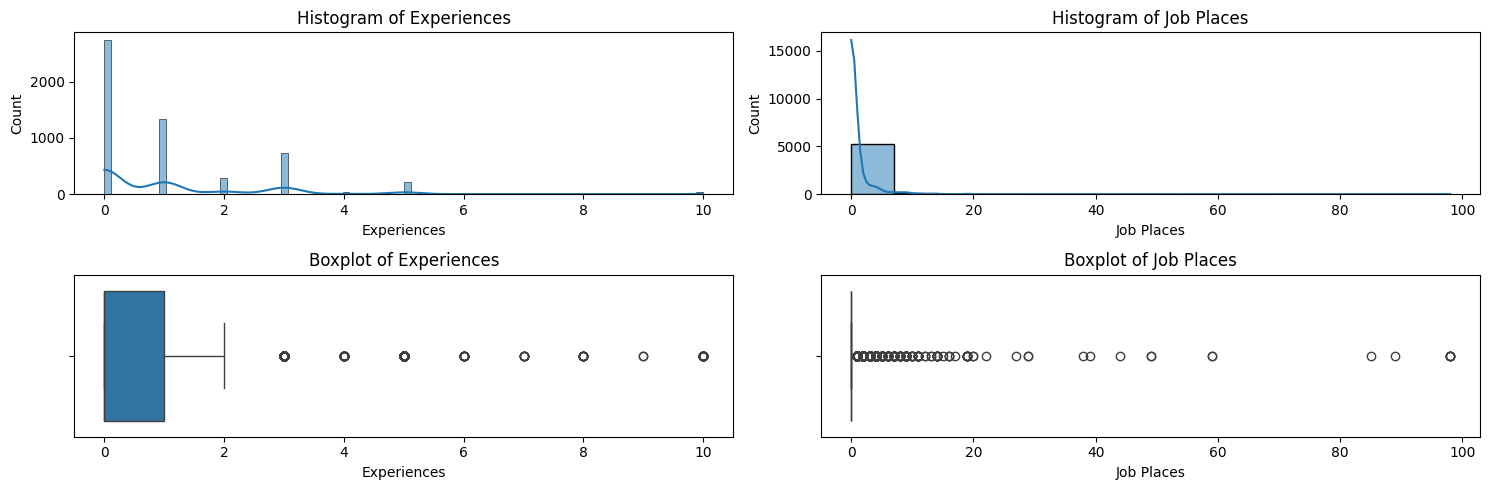

In [17]:
columns_to_plot = [ 'Experiences', 'Job Places']

plt.figure(figsize=(15, 5))


for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, len(columns_to_plot), i)
    sns.histplot(num[column], kde=True)
    plt.title(f"Histogram of {column}")
    
    plt.subplot(2, len(columns_to_plot), i + len(columns_to_plot))
    sns.boxplot(x=num[column])
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In [18]:

num['Experiences'] = np.log1p(num['Experiences'])
num['Job Places'] = np.log1p(num['Job Places'])

C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\594987390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Experiences'] = np.log1p(num['Experiences'])
C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\594987390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Job Places'] = np.log1p(num['Job Places'])


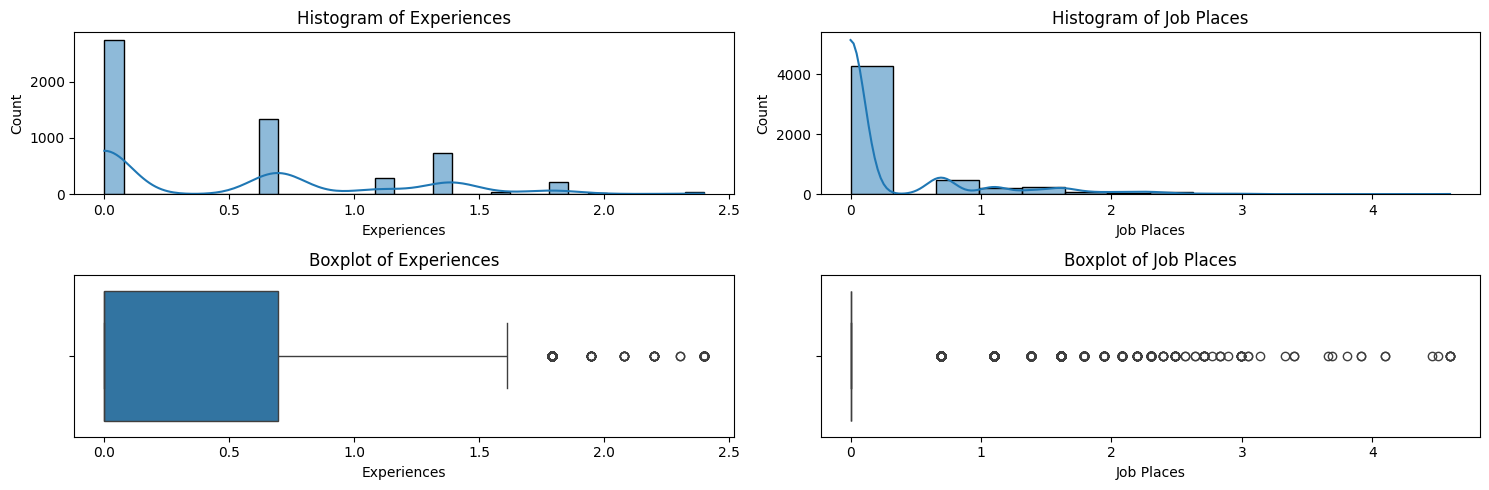

In [19]:
columns_to_plot = ['Experiences', 'Job Places']

plt.figure(figsize=(15, 5))


for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, len(columns_to_plot), i)
    sns.histplot(num[column], kde=True)
    plt.title(f"Histogram of {column}")
    
    plt.subplot(2, len(columns_to_plot), i + len(columns_to_plot))
    sns.boxplot(x=num[column])
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In [20]:
from scipy import stats

num['Experiences'], lambda_value = stats.boxcox(num['Experiences'] + 1)
num['Job Places'], _ = stats.boxcox(num['Job Places'] + 1) 

C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\3972112483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Experiences'], lambda_value = stats.boxcox(num['Experiences'] + 1)
C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\3972112483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Job Places'], _ = stats.boxcox(num['Job Places'] + 1)


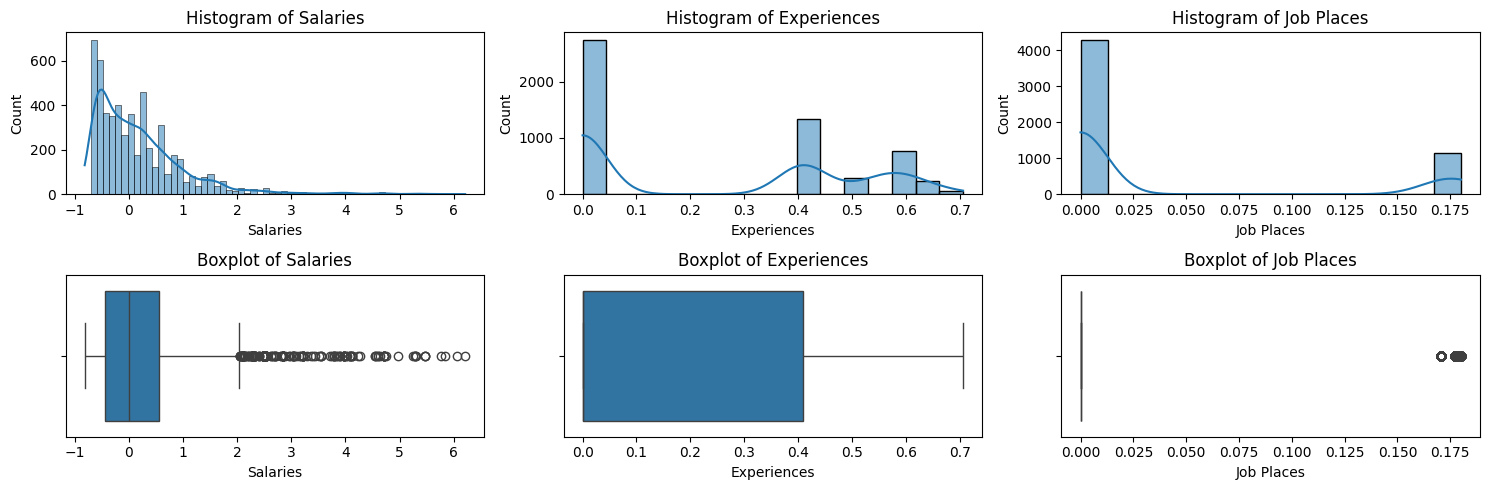

In [22]:
columns_to_plot = ['Salaries', 'Experiences', 'Job Places']

plt.figure(figsize=(15, 5))


for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, len(columns_to_plot), i)
    sns.histplot(num[column], kde=True)
    plt.title(f"Histogram of {column}")
    
    plt.subplot(2, len(columns_to_plot), i + len(columns_to_plot))
    sns.boxplot(x=num[column])
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\2686599279.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(num['Job Places'], shade=True)


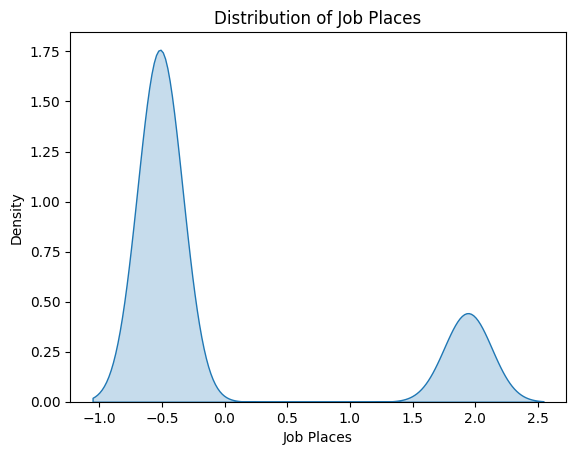

C:\Users\Фархат\AppData\Local\Temp\ipykernel_13444\2686599279.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(num['Experiences'], shade=True)


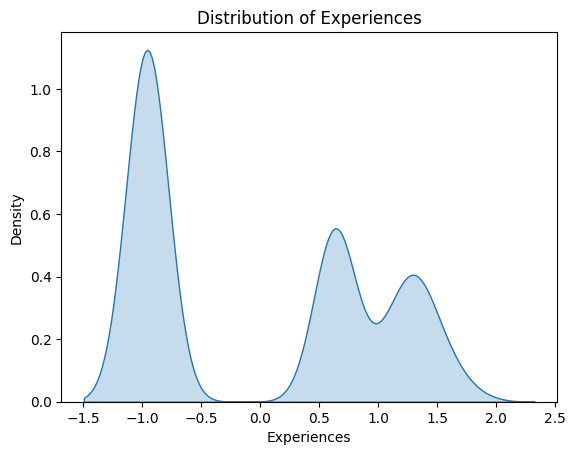

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(num['Job Places'], shade=True)
plt.title('Distribution of Job Places')
plt.show()

sns.kdeplot(num['Experiences'], shade=True)
plt.title('Distribution of Experiences')
plt.show()

In [12]:
num = data[num_features]

In [5]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(num_features)

['Salaries', 'Experiences', 'Working Condition', 'Educations', 'Job Places', 'Kazakh', 'Russian', 'English', 'Chinese', 'Turkish', 'seasonal', 'permanent', 'temporary', 'remote', 'unpaid_intern', 'paid_intern', 'no_intern', 'Abay_reg', 'Almaty', 'Almaty_reg', 'Astana', 'Atyrau_reg', 'Aqmola_reg', 'Aqtobe_reg', 'West_kz_reg', 'Zhambyl_reg', 'Zhetisu_reg', 'Mangistau_reg', 'Pavlodar_reg', 'North_kz_reg', 'Turkistan_reg', 'Shymkent', 'East_kz_reg', 'Qaragandy_reg', 'Qostanay_reg', 'Qyzylorda_reg', 'Ulytau_reg', 'rotational', 'other_specific_jobs', 'shift_based', 'part_time_work_week', 'part_time', 'full_day']


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, root_mean_squared_error

In [67]:
features = num[num_features].drop(columns = ['Salaries'])
target = data['Salaries'] 

In [68]:
features.columns

Index(['Experiences', 'Working Condition', 'Educations', 'Job Places',
       'Kazakh', 'Russian', 'English', 'Chinese', 'Turkish', 'seasonal',
       'permanent', 'temporary', 'remote', 'unpaid_intern', 'paid_intern',
       'no_intern', 'Abay_reg', 'Almaty', 'Almaty_reg', 'Astana', 'Atyrau_reg',
       'Aqmola_reg', 'Aqtobe_reg', 'West_kz_reg', 'Zhambyl_reg', 'Zhetisu_reg',
       'Mangistau_reg', 'Pavlodar_reg', 'North_kz_reg', 'Turkistan_reg',
       'Shymkent', 'East_kz_reg', 'Qaragandy_reg', 'Qostanay_reg',
       'Qyzylorda_reg', 'Ulytau_reg', 'rotational', 'other_specific_jobs',
       'shift_based', 'part_time_work_week', 'part_time', 'full_day'],
      dtype='object')

In [34]:
features['Working Condition'].unique()

array([0., 1., 2.])

In [69]:
features.isna().sum()

Experiences            0
Working Condition      0
Educations             0
Job Places             0
Kazakh                 0
Russian                0
English                0
Chinese                0
Turkish                0
seasonal               0
permanent              0
temporary              0
remote                 0
unpaid_intern          0
paid_intern            0
no_intern              0
Abay_reg               0
Almaty                 0
Almaty_reg             0
Astana                 0
Atyrau_reg             0
Aqmola_reg             0
Aqtobe_reg             0
West_kz_reg            0
Zhambyl_reg            0
Zhetisu_reg            0
Mangistau_reg          0
Pavlodar_reg           0
North_kz_reg           0
Turkistan_reg          0
Shymkent               0
East_kz_reg            0
Qaragandy_reg          0
Qostanay_reg           0
Qyzylorda_reg          0
Ulytau_reg             0
rotational             0
other_specific_jobs    0
shift_based            0
part_time_work_week    0


In [383]:
data.shape

(5412, 53)

In [ ]:
features = num[num_features].drop(columns = ['Salaries'])
target = data['Salaries'] 

### Linear Regression

In [219]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=250)


model = LinearRegression()
model.fit(X_train, y_train)



y_pred = model.predict(X_test)

print('\tLinear Regression:')
print(f'R2 square: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

	Linear Regression:
R2 square: 0.26379389542712706
MSE: 8569696842.003358
RMSE: 92572.65709702492


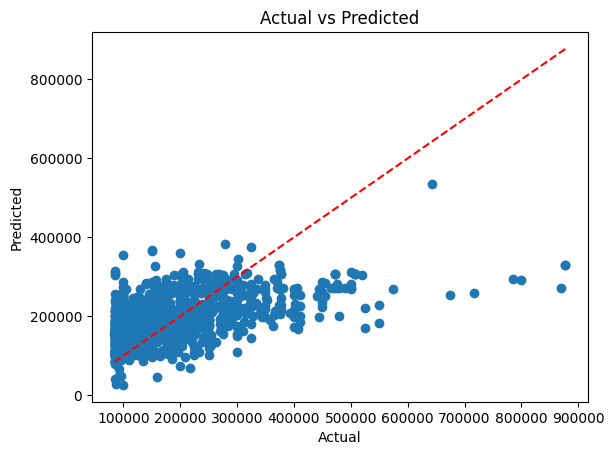

In [221]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Random Forest Regressor

In [109]:
features = num[num_features].drop(columns = ['Salaries']) # Add more features as needed
target = data['Salaries'] 

In [110]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=250)

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

model = RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("\tRandom Forest Regressor: ")
print("R2:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
print("RMSEL:", root_mean_squared_error(y_test,preds))

	Random Forest Regressor: 
R2: 0.4280664806443638
MSE: 6657506429.536419
RMSEL: 81593.54404324168


In [113]:
features['Experience_Job_Interaction'] = features['Experiences'] * features['Job Places']

### Gradient Boosting

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, min_samples_split = 2 ,subsample = 0.8, random_state=42)
gbr.fit(X_train, y_train)


y_pred = gbr.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2: {r2}')

Mean Squared Error: 9132513030.564537
R2: 0.3302235822765305


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

gbr = GradientBoostingRegressor(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}


grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2: {r2}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.9}
Mean Squared Error: 9154631543.771587
R2: 0.3286014155748125


In [220]:
target.name = 'Salaries'
correlation = pd.concat([features, target], axis=1).corr()
print(correlation['Salaries'].sort_values(ascending=False))

Salaries                      1.000000
Working Condition             0.205842
Educations                    0.205281
Experiences                   0.192676
Qostanay_reg                  0.186117
Astana                        0.144262
English                       0.138314
Job Places                    0.115548
full_day                      0.090174
shift_based                   0.085645
permanent                     0.072084
Almaty                        0.058944
Qaragandy_reg                 0.058462
paid_intern                   0.048397
Chinese                       0.024398
unpaid_intern                 0.017720
Russian                       0.017588
no_intern                     0.006111
remote                        0.004518
other_specific_jobs          -0.000169
Abay_reg                     -0.001691
Kazakh                       -0.001939
rotational                   -0.011234
Mangistau_reg                -0.013953
Atyrau_reg                   -0.015309
Turkish                  

In [340]:
data.to_csv('AI_enbek_kz_cleaned.csv', index = False)

## NLP

In [270]:
import pandas as pd
from langdetect import detect


data['kz_or_rus'] = data['Professional skills'].apply(lambda x: detect(str(x)))

print(data[['Professional skills', 'kz_or_rus']].head())


                                 Professional skills kz_or_rus
0  ежедневная чистка кофемашин чайников термосов ...        ru
1  наличие соответствующего образования опыт рабо...        ru
2                                                any        tl
3  есеп жоспарлау және есептілік қызметкерлердің ...        uk
4  среднее медицинское образование опыт работы с ...        ru


In [271]:
def map_to_kz_ru(lang):
    if lang == 'ru':
        return 'ru'
    elif lang in ['kk', 'mk', 'bg', 'uk']:
        return 'kz'
    else:
        return 'unknown'

data['kz_or_rus'] = data['kz_or_rus'].apply(map_to_kz_ru)

In [272]:
data['kz_or_rus'].unique()

array(['ru', 'unknown', 'kz'], dtype=object)

In [273]:
obj_features = data.select_dtypes(include=['object']).columns.tolist()
print(obj_features)

nlp = data[obj_features]

['Titles', 'SubTitle', 'Fields', 'Locations', 'Dates', 'Demands', 'Responsibilities', 'Professional skills', 'Soft skills', 'kz_or_rus']


In [274]:
kz = nlp[nlp['kz_or_rus'] == 'kz']
ru = nlp[nlp['kz_or_rus'] == 'ru']

In [276]:
import re

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text) 
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d+', '', text)      
    return text


nlp['Professional skills'] = nlp['Professional skills'].apply(clean_text)
nlp['Titles'] = nlp['Titles'].apply(clean_text)
nlp['SubTitle'] = nlp['SubTitle'].apply(clean_text)
nlp['Locations'] = nlp['Locations'].apply(clean_text)
nlp['Demands'] = nlp['Demands'].apply(clean_text)
nlp['Responsibilities'] = nlp['Responsibilities'].apply(clean_text)
nlp['Soft skills'] = nlp['Soft skills'].apply(clean_text)


In [277]:
nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Titles               5412 non-null   object
 1   SubTitle             5412 non-null   object
 2   Fields               5412 non-null   object
 3   Locations            5412 non-null   object
 4   Dates                5412 non-null   object
 5   Demands              5412 non-null   object
 6   Responsibilities     5412 non-null   object
 7   Professional skills  5412 non-null   object
 8   Soft skills          5412 non-null   object
 9   kz_or_rus            5412 non-null   object
dtypes: object(10)
memory usage: 422.9+ KB


In [278]:
text_columns = ['Titles', 'SubTitle', 'Fields', 'Locations', 'Demands', 'Responsibilities', 'Professional skills', 'Soft skills']

def combine_text_fields(row):
    return ' '.join(str(row[col]) for col in text_columns if pd.notnull(row[col]))

nlp['combined_text'] = nlp.apply(combine_text_fields, axis=1)

In [285]:
custom_stopwords = ['және', 'мен', 'барлық', 'үшін', 'бір', 'соң', 'болып', 
                    'и', 'в', 'на', 'с', 'по', 'что', 'как', 'это', 'к']    

TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    stop_words=custom_stopwords  
)

TfidfVectorizer(max_features=3000, ngram_range=(1, 2),
                stop_words=['және', 'мен', 'барлық', 'үшін', 'бір', 'соң',
                            'болып', 'и', 'в', 'на', 'с', 'по', 'что', 'как',
                            'это', 'к'])

In [280]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


russian_sw = stopwords.words('russian')
kazakh_sw = ['және', 'мен', 'бір', 'қосымша', 'т.б.', 'тағы', 'бастап'] 
all_sw = set(russian_sw + kazakh_sw)


def clean_texx(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in all_sw]
    return ' '.join(tokens)

nlp['combined_text'] = nlp['combined_text'].apply(clean_texx)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Фархат\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NLP MODEL

In [281]:
from sklearn.model_selection import train_test_split

X = nlp['combined_text']
y = data['Salaries'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor

nlp_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500)),
    ('model', RandomForestRegressor())
])

In [283]:
nlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=500)),
                ('model', RandomForestRegressor())])

In [284]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = nlp_pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 77361.40511195608
R2 Score: 0.5610770896375666


### Combining Together NLP, ML

In [290]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [292]:

text_transformer = TfidfVectorizer(
    max_features=3000,
    stop_words=custom_stopwords,  
    ngram_range=(1, 2)
)

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

In [300]:
true_numeric_features = [col for col in num_features if data[col].nunique() > 6]
print(true_numeric_features)

['Salaries', 'Experiences', 'Job Places']


In [323]:
filtered_columns = [col for col in data.columns if col not in nlp.columns]
filtered_columns = [col for col in filtered_columns if  col not in true_numeric_features]

In [324]:
text_col = 'combined_text'
categorical_cols = filtered_columns
numeric_cols = ['Experiences', 'Job Places']
target_col = 'Salaries'

In [362]:
preprocessor = ColumnTransformer(transformers=[
    ('text', text_transformer, text_col),
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols)
])

## RandomForest

In [363]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [364]:
df_clean = nlp[text_col]
aaa = data[categorical_cols + numeric_cols + [target_col]]
df_clean = pd.concat([df_clean.reset_index(drop = True), aaa.reset_index(drop = True)], axis = 1)

In [365]:
from sklearn.model_selection import train_test_split


df_clean = df_clean.dropna()
X = df_clean.drop(columns = ['Salaries'])
y = df_clean['Salaries']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['және',
                                                                              'мен',
                                                                              'барлық',
                                                                              'үшін',
                                                                              'бір',
                                                                              'соң',
                                                                              'болып',
                                                                              'и',
                                                                              'в',
                                                                              'на',
                                                                              'с',
                                                                              'по',
                                                                              'что',
                                                                              'как',
                                                                              'это',
                                                                              'к']),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Working Condition',
                                                   'Educations', 'Kazakh',
                                                   'Russian', 'En...
                                                   'unpaid_intern',
                                                   'paid_intern', 'no_intern',
                                                   'Abay_reg', 'Almaty',
                                                   'Almaty_reg', 'Astana',
                                                   'Atyrau_reg', 'Aqmola_reg',
                                                   'Aqtobe_reg', 'West_kz_reg',
                                                   'Zhambyl_reg', 'Zhetisu_reg',
                                                   'Mangistau_reg',
                                                   'Pavlodar_reg',
                                                   'North_kz_reg',
                                                   'Turkistan_reg', 'Shymkent',
                                                   'East_kz_reg', ...]),
                                                 ('num', StandardScaler(),
                                                  ['Experiences',
                                                   'Job Places'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [366]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model_pipeline.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 73561.44115788933
R² Score: 0.6031375494114051


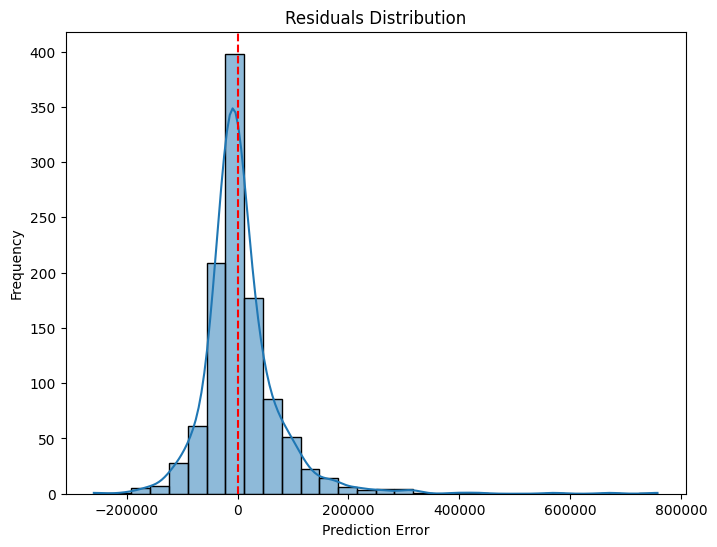

In [367]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

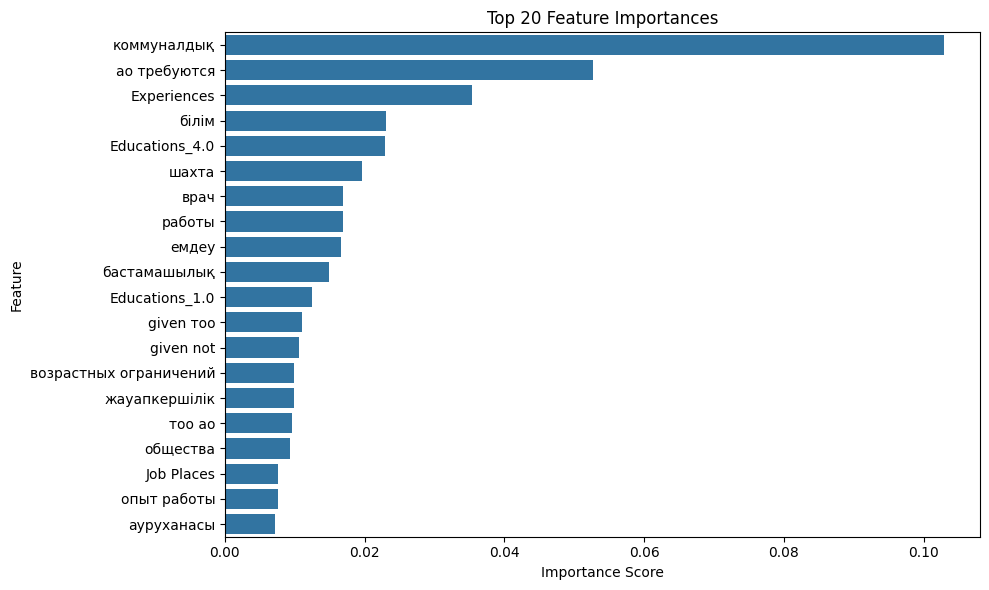

In [370]:
preprocessor = model_pipeline.named_steps['preprocessing']
regressor = model_pipeline.named_steps['model']


text_features = preprocessor.named_transformers_['text'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(preprocessor.transformers[1][2])
num_features = preprocessor.transformers[2][2]


feature_names = list(text_features) + list(cat_features) + list(num_features)


importances = pd.Series(regressor.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
from xgboost import XGBRegressor

### XGBoost

In [387]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['және',
                                                                              'мен',
                                                                              'барлық',
                                                                              'үшін',
                                                                              'бір',
                                                                              'соң',
                                                                              'болып',
                                                                              'и',
                                                                              'в',
                                                                              'на',
                                                                              'с',
                                                                              'по',
                                                                              'что',
                                                                              'как',
                                                                              'это',
                                                                              'к']),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Working Condition',
                                                   'Educations', 'Kazakh',
                                                   'Russian', 'Eng...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [392]:
from sklearn.metrics import mean_squared_error

y_pred_xgb = xgb_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test,y_pred_xgb)
rmse = root_mean_squared_error(y_test,y_pred_xgb)
print(f"XGBoost MSE: {mse:.2f}")
print(f'XGBoost R2: {r2}')
print(f'XGBoost RMSE: {rmse:.2f}')

XGBoost MSE: 5608671513.54
XGBoost R2: 0.5886613134899595
XGBoost RMSE: 74891.06


### Catboost

In [395]:
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        verbose=0,
        random_seed=42
    ))
])

catboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['және',
                                                                              'мен',
                                                                              'барлық',
                                                                              'үшін',
                                                                              'бір',
                                                                              'соң',
                                                                              'болып',
                                                                              'и',
                                                                              'в',
                                                                              'на',
                                                                              'с',
                                                                              'по',
                                                                              'что',
                                                                              'как',
                                                                              'это',
                                                                              'к']),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Working Condition',
                                                   'Educations', 'Kazakh',
                                                   'Russian', 'Eng...
                                                   'paid_intern', 'no_intern',
                                                   'Abay_reg', 'Almaty',
                                                   'Almaty_reg', 'Astana',
                                                   'Atyrau_reg', 'Aqmola_reg',
                                                   'Aqtobe_reg', 'West_kz_reg',
                                                   'Zhambyl_reg', 'Zhetisu_reg',
                                                   'Mangistau_reg',
                                                   'Pavlodar_reg',
                                                   'North_kz_reg',
                                                   'Turkistan_reg', 'Shymkent',
                                                   'East_kz_reg', ...]),
                                                 ('num', StandardScaler(),
                                                  ['Experiences',
                                                   'Job Places'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x00000278A343AFF0>)])

In [398]:
y_pred_cat = catboost_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred_cat)
r2 = r2_score(y_test,y_pred_cat)
rmse = root_mean_squared_error(y_test,y_pred_cat)
print(f"Catboost MSE: {mse:.2f}")
print(f'Catboost R2: {r2}')
print(f'Catboost RMSE: {rmse:.2f}')

Catboost MSE: 5368270814.47
Catboost R2: 0.6062922457977351
Catboost RMSE: 73268.48


In [411]:
from sklearn.linear_model import Ridge

ridgeee = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(
        alpha=1.0
    ))
])

ridgeee.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['және',
                                                                              'мен',
                                                                              'барлық',
                                                                              'үшін',
                                                                              'бір',
                                                                              'соң',
                                                                              'болып',
                                                                              'и',
                                                                              'в',
                                                                              'на',
                                                                              'с',
                                                                              'по',
                                                                              'что',
                                                                              'как',
                                                                              'это',
                                                                              'к']),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Working Condition',
                                                   'Educations', 'Kazakh',
                                                   'Russian', 'Eng...
                                                   'temporary', 'remote',
                                                   'unpaid_intern',
                                                   'paid_intern', 'no_intern',
                                                   'Abay_reg', 'Almaty',
                                                   'Almaty_reg', 'Astana',
                                                   'Atyrau_reg', 'Aqmola_reg',
                                                   'Aqtobe_reg', 'West_kz_reg',
                                                   'Zhambyl_reg', 'Zhetisu_reg',
                                                   'Mangistau_reg',
                                                   'Pavlodar_reg',
                                                   'North_kz_reg',
                                                   'Turkistan_reg', 'Shymkent',
                                                   'East_kz_reg', ...]),
                                                 ('num', StandardScaler(),
                                                  ['Experiences',
                                                   'Job Places'])])),
                ('model', Ridge())])

In [414]:
y_pred_ridge = ridgeee.predict(X_test)
mse = mean_squared_error(y_test, y_pred_ridge)
r2 = r2_score(y_test,y_pred_ridge)
rmse = root_mean_squared_error(y_test,y_pred_ridge)
print(f"Ridge MSE: {mse:.2f}")
print(f'Ridge R2: {r2}')
print(f'Ridge RMSE: {rmse:.2f}')

Ridge MSE: 5914487444.11
Ridge R2: 0.5662328430598176
Ridge RMSE: 76905.70


In [415]:
df_clean

,combined_text,Working Condition,Educations,Kazakh,Russian,English,Chinese,Turkish,seasonal,permanent,...,Ulytau_reg,rotational,other_specific_jobs,shift_based,part_time_work_week,part_time,full_day,Experiences,Job Places,Salaries
0,ас бөлме жұмысшысы кофеледи Тұру тамақтану бол...,0.0,2.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1,215000
1,домна пешінің бункершісі бункеровщик доменной ...,1.0,3.0,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,305040
2,заңгер ведущий юрист сектора правового сопрово...,0.0,1.0,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,1,85000
3,бас бухгалтер главный бухгалтер Қаржы бухгалте...,0.0,4.0,3,3,2,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,1,225000
4,мейіргер медицинская сестра школу Медицина фар...,0.0,2.0,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,ұсімдіктерді күтіп ұстау жөніндегі жұмысшы сад...,0.0,1.0,0,2,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,85000
5408,тәрбиешінің көмекшісі помощник воспитателя мин...,0.0,3.0,3,3,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,110000
5409,тәрбиешінің көмекшісі помощник воспитателя Біл...,0.0,1.0,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,87000
5410,сатып алушы государственный закупщик Қаржы бух...,0.0,4.0,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,1,219511


# Neural Networks

In [416]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error


X = df_clean.drop('Salaries', axis=1)
y = df_clean['Salaries']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


text_features = ['combined_text']
numeric_features = ['Working Condition', 'Educations']  
categorical_features = filtered_columns 


preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'combined_text'),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])



nn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42
    ))
])


nn_pipeline.fit(X_train, y_train)


y_pred_nn = nn_pipeline.predict(X_test)


mse = mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test,y_pred_nn)
rmse = root_mean_squared_error(y_test,y_pred_nn)
print(f"NN mse: {mse}")
print(f"NN r2: {r2}")
print(f"NN rmse: {rmse}")

NN mse: 5371089481.012815
NN r2: 0.606085525438052
NN rmse: 73287.71712239928
